# Results Summary Analysis (Reader-Friendly)

This notebook turns `results_summary_by_settings.csv` into a compact, readable analysis report.

## What you will get
- Data quality checks and coverage overview
- Method-level long-format table for comparisons
- Main comparison plot under a configurable filter slice
- Best setting per method and pairwise deltas
- Optional CSV exports for downstream reporting


## 1) Setup

Imports and display settings used throughout the notebook.


In [43]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 220)
pd.set_option('display.precision', 3)


## 2) Load Data

We load the summary CSV and preview the first few rows.


In [44]:
CSV_PATH = Path('results_summary_by_settings.csv')
assert CSV_PATH.exists(), f'Missing file: {CSV_PATH}'

df = pd.read_csv(CSV_PATH)
print(f'Loaded {CSV_PATH} with shape: {df.shape}')
display(df.head(5))


Loaded results_summary_by_settings.csv with shape: (391, 24)


,dataset,degree,gt,gen,label_source,em_match,em_select,em_ensemble,n_rows,n_files,n_seeds,goat_mean,goat_std,goat_count,goatcw_mean,goatcw_std,goatcw_count,eta_mean,eta_std,eta_count,ours_fr_mean,ours_fr_std,ours_fr_count,seeds
0,colored_mnist,NaN,0,0,pseudo,prototypes,bic,False,3,3,3,61.340,0.352,3,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,0|1|2
1,colored_mnist,NaN,0,0,pseudo,prototypes,bic,True,3,3,3,61.340,0.352,3,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,0|1|2
2,colored_mnist,NaN,0,1,pseudo,prototypes,bic,False,3,3,3,72.227,2.870,3,62.467,7.200,3,49.873,4.417,3,68.627,3.737,3,0|1|2
3,colored_mnist,NaN,0,1,pseudo,prototypes,bic,True,3,3,3,72.227,2.870,3,58.933,0.304,3,54.490,6.323,3,68.730,3.545,3,0|1|2
4,colored_mnist,NaN,0,1,pseudo,pseudo,bic,False,3,3,3,72.227,2.870,3,61.387,5.706,3,41.887,3.677,3,68.777,5.253,3,0|1|2


## 3) Quick Data Dictionary

Key columns used in the analysis:
- `dataset`, `degree`, `gt`, `gen`: dataset and experiment setting axes
- `label_source`, `em_match`, `em_select`, `em_ensemble`: labeling/EM configuration
- `*_mean`, `*_std`, `*_count`: method-specific aggregated accuracy stats
- `seeds`, `n_seeds`: seed metadata for reproducibility checks


## 4) Sanity Checks

Check basic coverage and consistency of seed metadata.


In [45]:
def parse_seeds(s):
    if pd.isna(s) or s == '':
        return []
    return [int(x) for x in str(s).split('|') if x != '']

df['seed_list'] = df['seeds'].apply(parse_seeds)
df['seed_count_from_list'] = df['seed_list'].apply(len)

dataset_values = sorted(df['dataset'].dropna().unique().tolist())
gt_values = sorted(df['gt'].dropna().unique().tolist())
gen_values = sorted(df['gen'].dropna().unique().tolist())
seed_mismatch = int((df['n_seeds'] != df['seed_count_from_list']).sum())

print('Datasets:', dataset_values)
print('gt values:', gt_values)
print('gen values:', gen_values)
print('Rows where n_seeds != parsed seeds:', seed_mismatch)

display(
    df[
        ['dataset','degree','gt','gen','label_source','em_match','em_select','em_ensemble','n_rows','n_files','n_seeds','seeds']
    ].head(10)
)


Datasets: ['colored_mnist', 'covtype', 'portraits', 'rotated_mnist']
gt values: [0, 1, 2, 3]
gen values: [0, 1, 2, 3]
Rows where n_seeds != parsed seeds: 0


,dataset,degree,gt,gen,label_source,em_match,em_select,em_ensemble,n_rows,n_files,n_seeds,seeds
0,colored_mnist,NaN,0,0,pseudo,prototypes,bic,False,3,3,3,0|1|2
1,colored_mnist,NaN,0,0,pseudo,prototypes,bic,True,3,3,3,0|1|2
2,colored_mnist,NaN,0,1,pseudo,prototypes,bic,False,3,3,3,0|1|2
3,colored_mnist,NaN,0,1,pseudo,prototypes,bic,True,3,3,3,0|1|2
4,colored_mnist,NaN,0,1,pseudo,pseudo,bic,False,3,3,3,0|1|2
5,colored_mnist,NaN,0,1,pseudo,pseudo,bic,True,3,3,3,0|1|2
6,colored_mnist,NaN,0,2,pseudo,prototypes,bic,False,3,3,3,0|1|2
7,colored_mnist,NaN,0,2,pseudo,prototypes,bic,True,3,3,3,0|1|2
8,colored_mnist,NaN,0,2,pseudo,pseudo,bic,False,3,3,3,0|1|2
9,colored_mnist,NaN,0,2,pseudo,pseudo,bic,True,3,3,3,0|1|2


## 5) Coverage by Setting

How many summary rows/files we have for each `(dataset, degree, gt, gen)` combination.


In [46]:
coverage = (
    df.groupby(['dataset', 'degree', 'gt', 'gen'], dropna=False)
      .agg(
          n_setting_rows=('dataset', 'size'),
          n_files=('n_files', 'sum'),
          n_seeds=('n_seeds', 'max'),
      )
      .reset_index()
      .sort_values(['dataset', 'degree', 'gt', 'gen'])
)



## 6) Convert to Long Format (Method-Centric)

A tidy table makes ranking, plotting, and pairwise deltas much simpler.


In [47]:
METHODS = ['goat', 'goatcw', 'eta', 'ours_fr']

long_rows = []
for m in METHODS:
    cols = [
        'dataset', 'degree', 'gt', 'gen',
        'label_source', 'em_match', 'em_select', 'em_ensemble',
        'seeds', 'n_rows', 'n_files', 'n_seeds',
        f'{m}_mean', f'{m}_std', f'{m}_count',
    ]
    sub = df[cols].copy()
    sub = sub.rename(columns={f'{m}_mean': 'acc_mean', f'{m}_std': 'acc_std', f'{m}_count': 'acc_count'})
    sub['method'] = m
    long_rows.append(sub)

df_long = pd.concat(long_rows, ignore_index=True)
df_long = df_long.dropna(subset=['acc_mean']).reset_index(drop=True)

print('Long-format shape:', df_long.shape)



Long-format shape: (1405, 16)


In [48]:
df_long[(df_long['dataset'] == 'covtype') & (df_long['gt'] == 0) & (df_long['gen'] == 1)& (df_long['n_rows']==3)]

,dataset,degree,gt,gen,label_source,em_match,em_select,em_ensemble,seeds,n_rows,n_files,n_seeds,acc_mean,acc_std,acc_count,method
59,covtype,NaN,0,1,pseudo,prototypes,bic,False,0|1|2,3,3,3,50.403,5.003,3,goat
61,covtype,NaN,0,1,pseudo,pseudo,bic,False,0|1|2,3,3,3,50.403,5.003,3,goat
440,covtype,NaN,0,1,pseudo,prototypes,bic,False,0|1|2,3,3,3,51.140,5.160,3,goatcw
442,covtype,NaN,0,1,pseudo,pseudo,bic,False,0|1|2,3,3,3,51.137,5.138,3,goatcw
778,covtype,NaN,0,1,pseudo,prototypes,bic,False,0|1|2,3,3,3,52.417,6.804,3,eta
780,covtype,NaN,0,1,pseudo,pseudo,bic,False,0|1|2,3,3,3,52.367,6.205,3,eta
1116,covtype,NaN,0,1,pseudo,prototypes,bic,False,0|1|2,3,3,3,51.217,5.360,3,ours_fr
1118,covtype,NaN,0,1,pseudo,pseudo,bic,False,0|1|2,3,3,3,50.983,5.245,3,ours_fr


## 7) Main Comparison Slice (Editable)

Set the filter below to define your primary comparison scenario.


In [49]:
FILTERS = {
    'label_source': 'pseudo',
    'em_match': 'prototypes',
    'em_select': 'bic',
    'em_ensemble': False,
}

sel = df_long.copy()
# for k, v in FILTERS.items():
#     sel = sel[sel[k] == v]

print('Active filters:', FILTERS)
print('Rows after filtering:', len(sel))



Active filters: {'label_source': 'pseudo', 'em_match': 'prototypes', 'em_select': 'bic', 'em_ensemble': False}
Rows after filtering: 1405


## 8) Plot: Accuracy vs `gen` by Dataset (Fixed `gt`)

This is the main visual comparison used in most summaries.


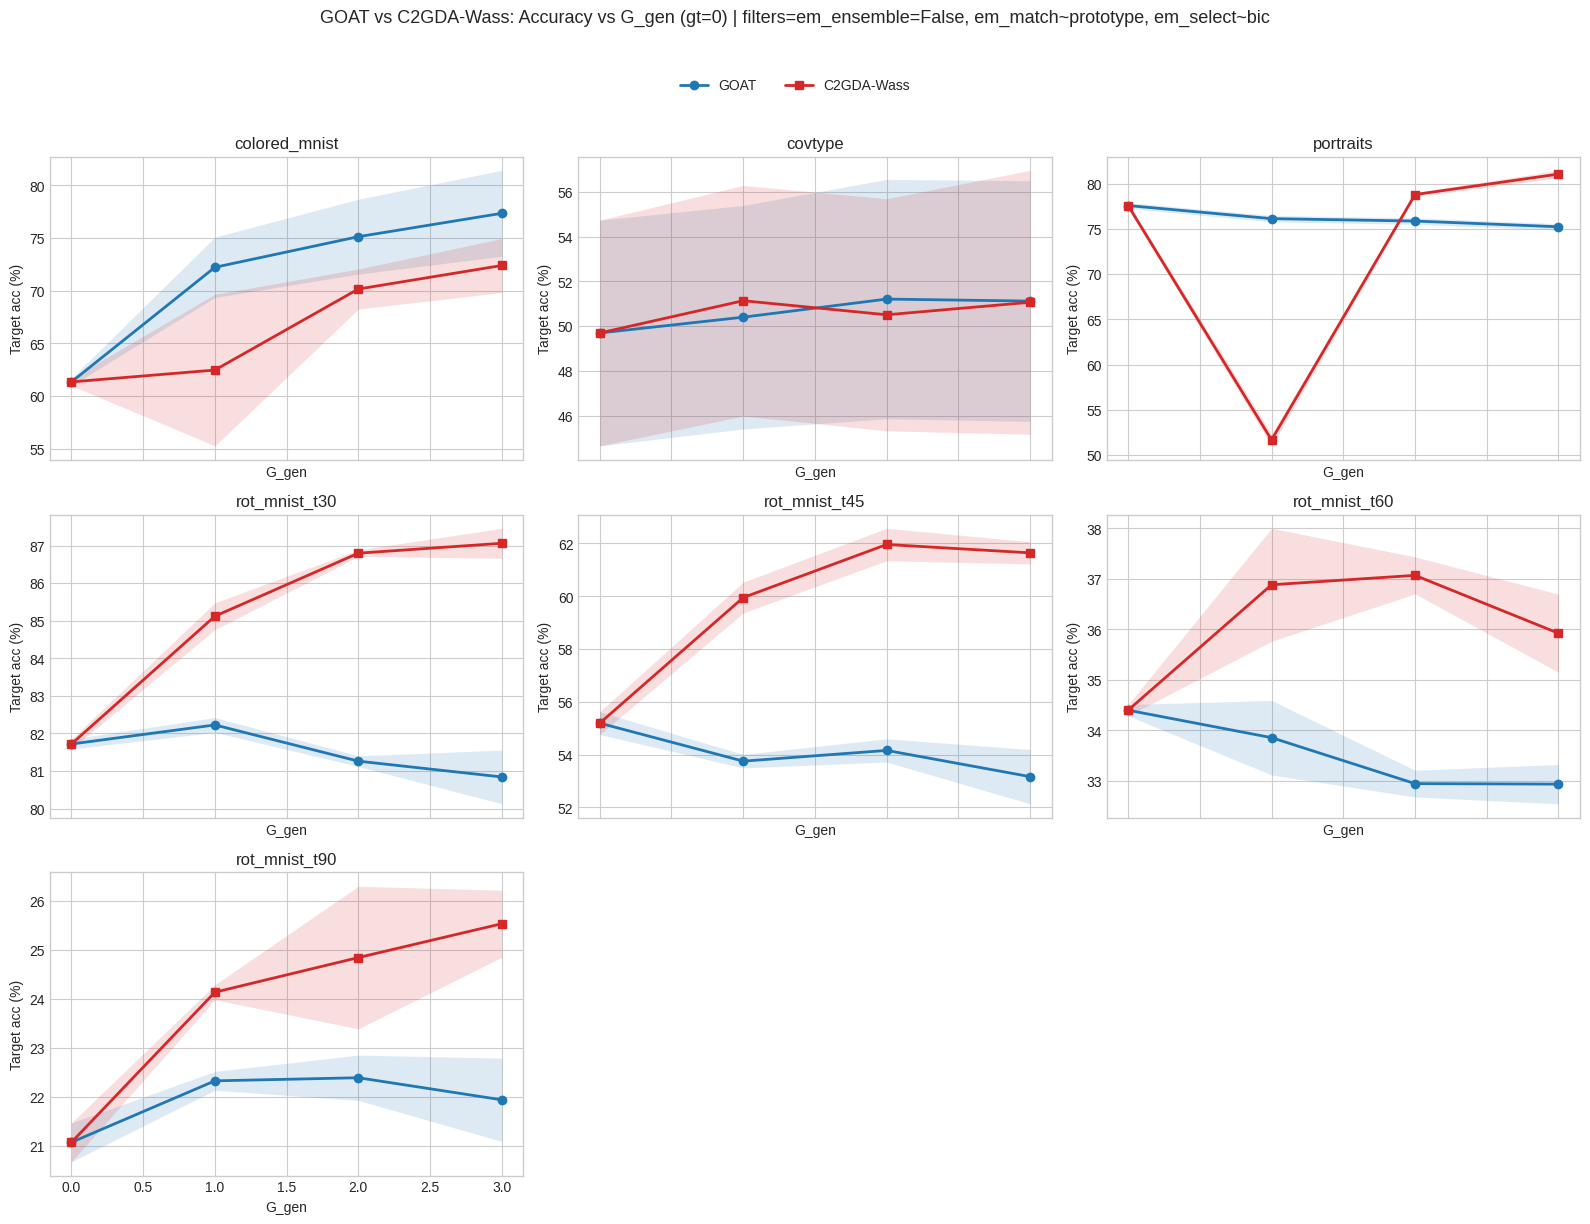

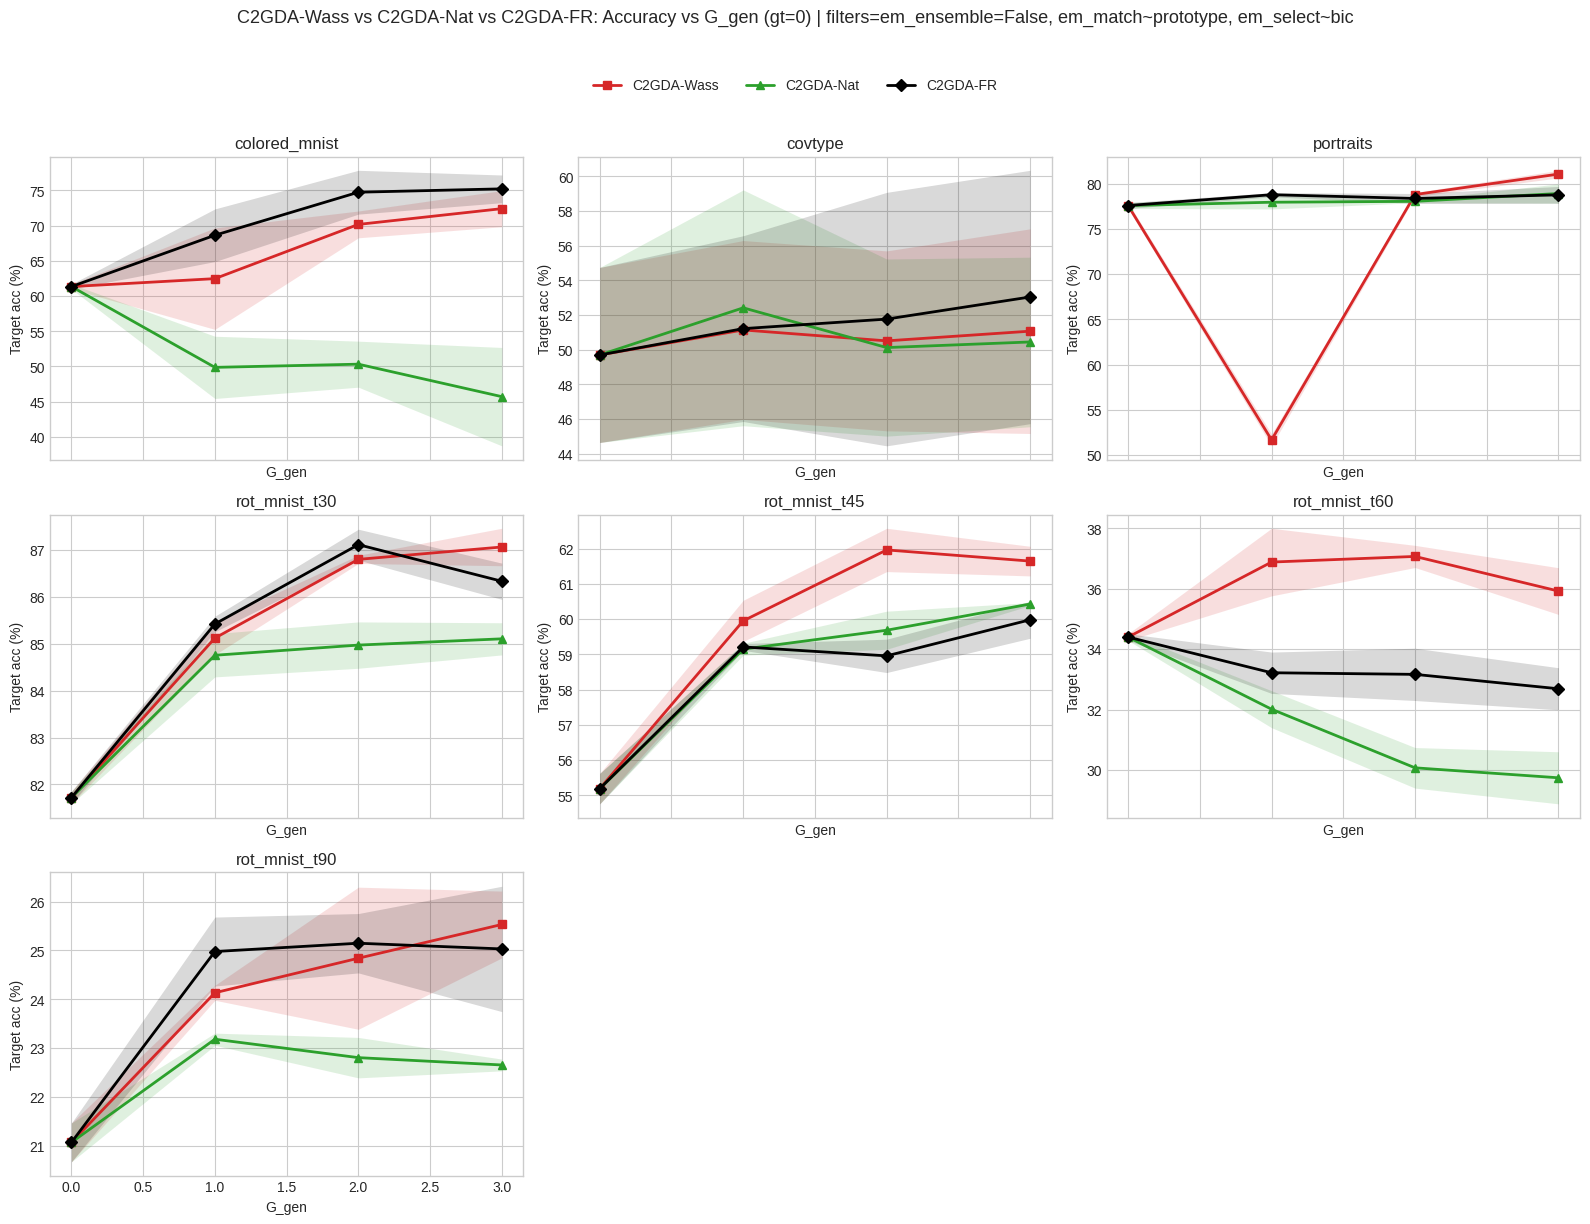

In [50]:
GT_TO_PLOT = 0
FILTERS_DESC = 'em_ensemble=False, em_match~prototype, em_select~bic'

if 'best' not in globals():
    if 'df_long' not in globals():
        raise NameError("`best` is not defined and `df_long` is unavailable. Run the long-table preparation cell first.")
    _plot_src = df_long.copy()
    _plot_src = _plot_src[
        (~_plot_src['em_ensemble'])
        & _plot_src['em_match'].str.contains('prototype', na=False)
        & _plot_src['em_select'].str.contains('bic', na=False)
    ]
    rank_df = _plot_src.sort_values(
        ['dataset', 'degree', 'gt', 'gen', 'method', 'acc_mean'],
        ascending=[True, True, True, True, True, False],
    )
    best = rank_df.groupby(['dataset', 'degree', 'gt', 'gen', 'method'], dropna=False).head(1).reset_index(drop=True)

plot_df = best[best['gt'] == GT_TO_PLOT].copy()


def ds_label(row):
    if row['dataset'] == 'rotated_mnist':
        return f"rot_mnist_t{int(row['degree'])}"
    return row['dataset']


plot_df['dataset_label'] = plot_df.apply(ds_label, axis=1)
datasets = sorted(plot_df['dataset_label'].unique().tolist())
method_groups = [
    ('GOAT vs C2GDA-Wass', ['goat', 'goatcw']),
    ('C2GDA-Wass vs C2GDA-Nat vs C2GDA-FR', ['goatcw', 'eta', 'ours_fr']),
]
method_name = {
    'goat': 'GOAT',
    'goatcw': 'C2GDA-Wass',
    'eta': 'C2GDA-Nat',
    'ours_fr': 'C2GDA-FR',
}
method_style = {
    'goat': dict(color='#1f77b4', marker='o'),
    'goatcw': dict(color='#d62728', marker='s'),
    'eta': dict(color='#2ca02c', marker='^'),
    'ours_fr': dict(color='black', marker='D'),
}

for group_title, methods in method_groups:
    n = len(datasets)
    ncols = 3
    nrows = int(np.ceil(n / ncols)) if n > 0 else 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3.8 * nrows), sharex=True)
    axes = np.array(axes).reshape(-1)

    for i, ds in enumerate(datasets):
        ax = axes[i]
        dsub = plot_df[plot_df['dataset_label'] == ds]
        shared_init = dsub.loc[dsub['gen'] == 0, 'acc_mean'].mean()
        shared_init_std = dsub.loc[dsub['gen'] == 0, 'acc_std'].fillna(0).mean()
        for m in methods:
            s = dsub[dsub['method'] == m].sort_values('gen').copy()
            if s.empty:
                continue
            if pd.notna(shared_init):
                if (s['gen'] == 0).any():
                    s.loc[s['gen'] == 0, 'acc_mean'] = shared_init
                    s.loc[s['gen'] == 0, 'acc_std'] = shared_init_std
                else:
                    s = pd.concat([
                        pd.DataFrame({'gen': [0], 'acc_mean': [shared_init], 'acc_std': [shared_init_std]}),
                        s,
                    ], ignore_index=True).sort_values('gen')
            x = s['gen'].to_numpy()
            y = s['acc_mean'].to_numpy()
            y_std = s['acc_std'].fillna(0).to_numpy()
            ax.plot(
                x,
                y,
                linewidth=2.0,
                label=method_name[m],
                **method_style[m],
            )
            ax.fill_between(
                x,
                y - y_std,
                y + y_std,
                color=method_style[m]['color'],
                alpha=0.15,
                linewidth=0,
            )
        ax.set_title(ds)
        ax.set_xlabel('G_gen')
        ax.set_ylabel('Target acc (%)')

    for j in range(len(datasets), len(axes)):
        axes[j].axis('off')

    if len(datasets) > 0:
        handles, labels = axes[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper center', ncol=len(methods), frameon=False, bbox_to_anchor=(0.5, 1.02))

    fig.suptitle(f'{group_title}: Accuracy vs G_gen (gt={GT_TO_PLOT}) | filters={FILTERS_DESC}', y=1.07, fontsize=13)
    fig.tight_layout()
    plt.show()


In [51]:
best[(best['dataset'] == 'covtype') & (best['gt'] == 0) & (best['gen'] == 1)]

,dataset,degree,gt,gen,label_source,em_match,em_select,em_ensemble,seeds,n_rows,n_files,n_seeds,acc_mean,acc_std,acc_count,method
53,covtype,NaN,0,1,pseudo,prototypes,bic,False,0|1|2,3,3,3,52.417,6.804,3,eta
54,covtype,NaN,0,1,pseudo,prototypes,bic,False,0|1|2,3,3,3,50.403,5.003,3,goat
55,covtype,NaN,0,1,pseudo,prototypes,bic,False,0|1|2,3,3,3,51.140,5.160,3,goatcw
56,covtype,NaN,0,1,pseudo,prototypes,bic,False,0|1|2,3,3,3,51.217,5.360,3,ours_fr


## 9) Best Setting per Method and Scenario

For each `(dataset, degree, gt, gen, method)`, keep the highest `acc_mean` row.


In [1]:
if 'df_long' not in globals():
    raise NameError("`df_long` is not defined. Run the long-table preparation cell first.")
df_long = df_long[(~df_long['em_ensemble']) & df_long['em_match'].str.contains('prototype', na=False) & df_long['em_select'].str.contains('bic', na=False)]
rank_df = df_long.sort_values(
    ['dataset', 'degree', 'gt', 'gen', 'method', 'acc_mean'],
    ascending=[True, True, True, True, True, False],
)
best = rank_df.groupby(['dataset', 'degree', 'gt', 'gen', 'method'], dropna=False).head(1).reset_index(drop=True)

best[best['dataset'].str.contains('colored_mnist')][
    ['dataset','degree','gt','gen','method','acc_mean','acc_std','label_source','em_match','em_select','em_ensemble','seeds']
]

best[
    ['dataset','degree','gt','gen','method','acc_mean','acc_std','label_source','em_match','em_select','em_ensemble','seeds','acc_mean','acc_std']
]


GT_TO_PLOT = 0
FILTERS_DESC = 'em_ensemble=False, em_match~prototype, em_select~bic'

if 'best' not in globals():
    if 'df_long' not in globals():
        raise NameError("`best` is not defined and `df_long` is unavailable. Run the long-table preparation cell first.")
    _plot_src = df_long.copy()
    _plot_src = _plot_src[
        (~_plot_src['em_ensemble'])
        & _plot_src['em_match'].str.contains('prototype', na=False)
        & _plot_src['em_select'].str.contains('bic', na=False)
    ]
    rank_df = _plot_src.sort_values(
        ['dataset', 'degree', 'gt', 'gen', 'method', 'acc_mean'],
        ascending=[True, True, True, True, True, False],
    )
    best = rank_df.groupby(['dataset', 'degree', 'gt', 'gen', 'method'], dropna=False).head(1).reset_index(drop=True)

plot_df = best[best['gt'] == GT_TO_PLOT].copy()


def ds_label(row):
    if row['dataset'] == 'rotated_mnist':
        return f"rot_mnist_t{int(row['degree'])}"
    return row['dataset']


plot_df['dataset_label'] = plot_df.apply(ds_label, axis=1)
datasets = sorted(plot_df['dataset_label'].unique().tolist())
method_groups = [
    ('GOAT vs C2GDA-Wass', ['goat', 'goatcw']),
    ('C2GDA-Wass vs C2GDA-Nat vs C2GDA-FR', ['goatcw', 'eta', 'ours_fr']),
]
method_name = {
    'goat': 'GOAT',
    'goatcw': 'C2GDA-Wass',
    'eta': 'C2GDA-Nat',
    'ours_fr': 'C2GDA-FR',
}
method_style = {
    'goat': dict(color='#1f77b4', marker='o'),
    'goatcw': dict(color='#d62728', marker='s'),
    'eta': dict(color='#2ca02c', marker='^'),
    'ours_fr': dict(color='black', marker='D'),
}

for group_title, methods in method_groups:
    n = len(datasets)
    ncols = 3
    nrows = int(np.ceil(n / ncols)) if n > 0 else 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3.8 * nrows), sharex=True)
    axes = np.array(axes).reshape(-1)

    for i, ds in enumerate(datasets):
        ax = axes[i]
        dsub = plot_df[plot_df['dataset_label'] == ds]
        shared_init = dsub.loc[dsub['gen'] == 0, 'acc_mean'].mean()
        shared_init_std = dsub.loc[dsub['gen'] == 0, 'acc_std'].fillna(0).mean()
        for m in methods:
            s = dsub[dsub['method'] == m].sort_values('gen').copy()
            if s.empty:
                continue
            if pd.notna(shared_init):
                if (s['gen'] == 0).any():
                    s.loc[s['gen'] == 0, 'acc_mean'] = shared_init
                    s.loc[s['gen'] == 0, 'acc_std'] = shared_init_std
                else:
                    s = pd.concat([
                        pd.DataFrame({'gen': [0], 'acc_mean': [shared_init], 'acc_std': [shared_init_std]}),
                        s,
                    ], ignore_index=True).sort_values('gen')
            x = s['gen'].to_numpy()
            y = s['acc_mean'].to_numpy()
            y_std = s['acc_std'].fillna(0).to_numpy()
            ax.plot(
                x,
                y,
                linewidth=2.0,
                label=method_name[m],
                **method_style[m],
            )
            ax.fill_between(
                x,
                y - y_std,
                y + y_std,
                color=method_style[m]['color'],
                alpha=0.15,
                linewidth=0,
            )
        ax.set_title(ds)
        ax.set_xlabel('G_gen')
        ax.set_ylabel('Target acc (%)')

    for j in range(len(datasets), len(axes)):
        axes[j].axis('off')

    if len(datasets) > 0:
        handles, labels = axes[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper center', ncol=len(methods), frameon=False, bbox_to_anchor=(0.5, 1.02))

    fig.suptitle(f'{group_title}: Accuracy vs G_gen (gt={GT_TO_PLOT}) | filters={FILTERS_DESC}', y=1.07, fontsize=13)
    fig.tight_layout()
    plt.show()




NameError: name 'df_long' is not defined

## 10) Pairwise Method Deltas (Split)

Group A compares `goatcw` against `goat`; Group B compares `eta` and `ours_fr` against `goatcw`.


In [10]:
wide = df_long.pivot_table(
    index=['dataset','degree','gt','gen','label_source','em_match','em_select','em_ensemble','seeds'],
    columns='method',
    values='acc_mean',
    aggfunc='first',
).reset_index()

if {'goat', 'goatcw'}.issubset(wide.columns):
    wide['delta_goatcw_minus_goat'] = wide['goatcw'] - wide['goat']
    display(
        wide[['dataset','degree','gt','gen','goat','goatcw','delta_goatcw_minus_goat']]
        .sort_values(['dataset','degree','gt','gen'])
        .head(20)
    )
else:
    print('Missing columns for Group A delta: goat/goatcw')

if {'goatcw', 'eta', 'ours_fr'}.issubset(wide.columns):
    wide['delta_eta_minus_goatcw'] = wide['eta'] - wide['goatcw']
    wide['delta_fr_minus_goatcw'] = wide['ours_fr'] - wide['goatcw']
    display(
        wide[['dataset','degree','gt','gen','goatcw','eta','ours_fr','delta_eta_minus_goatcw','delta_fr_minus_goatcw']]
        .sort_values(['dataset','degree','gt','gen'])
        .head(20)
    )
else:
    print('Missing columns for Group B deltas: goatcw/eta/ours_fr')


method,dataset,degree,gt,gen,delta_goatcw_minus_goat,delta_eta_minus_goatcw,delta_fr_minus_goatcw
0,rotated_mnist,30.0,0,0,NaN,NaN,NaN
1,rotated_mnist,30.0,0,0,NaN,NaN,NaN
2,rotated_mnist,30.0,0,0,0.000,81.720,81.720
3,rotated_mnist,30.0,0,1,2.893,-0.367,0.300
4,rotated_mnist,30.0,0,1,4.507,-0.610,0.457
5,rotated_mnist,30.0,0,1,2.893,-0.367,0.300
6,rotated_mnist,30.0,0,1,3.150,-0.623,0.367
7,rotated_mnist,30.0,0,2,5.533,-1.827,0.313
8,rotated_mnist,30.0,0,2,7.190,-2.040,0.427
9,rotated_mnist,30.0,0,2,5.533,-1.827,0.313


## 11) High-Variance Rows (Diagnostics)

These rows are useful to inspect unstable settings.


In [11]:
var_df = df_long.sort_values('acc_std', ascending=False)
display(
    var_df[
        ['dataset','degree','gt','gen','method','acc_mean','acc_std','acc_count','label_source','em_match','em_select','em_ensemble','seeds']
    ].head(30)
)


,dataset,degree,gt,gen,method,acc_mean,acc_std,acc_count,label_source,em_match,em_select,em_ensemble,seeds
732,colored_mnist,NaN,0,1,eta,47.027,10.398,3,pseudo,pseudo,bic,True,0|1|2
740,colored_mnist,NaN,0,3,eta,49.490,10.270,3,pseudo,pseudo,bic,True,0|1|2
739,colored_mnist,NaN,0,3,eta,51.000,9.028,3,pseudo,pseudo,bic,False,0|1|2
736,colored_mnist,NaN,0,2,eta,47.783,8.676,3,pseudo,pseudo,bic,True,0|1|2
734,colored_mnist,NaN,0,2,eta,45.093,8.605,3,pseudo,prototypes,bic,True,0|1|2
1132,covtype,NaN,2,1,ours_fr,52.147,8.441,3,pseudo,prototypes,bic,False,0|1|2
1133,covtype,NaN,2,1,ours_fr,51.933,8.240,3,pseudo,pseudo,bic,False,0|1|2
1121,covtype,NaN,0,2,ours_fr,52.500,8.189,3,pseudo,pseudo,bic,False,0|1|2
774,colored_mnist,NaN,3,3,eta,73.327,7.961,3,pseudo,prototypes,bic,True,0|1|2
773,colored_mnist,NaN,3,3,eta,73.043,7.876,3,pseudo,prototypes,bic,False,0|1|2


## 12) Optional Exports

Uncomment and run this cell when you want CSV outputs for reports or scripts.


In [12]:
OUT_DIR = Path('analysis_outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)

df_long.to_csv(OUT_DIR / 'results_summary_long.csv', index=False)
best.to_csv(OUT_DIR / 'best_setting_per_method.csv', index=False)
wide.to_csv(OUT_DIR / 'pairwise_deltas.csv', index=False)

print('Wrote:', OUT_DIR)


Wrote: analysis_outputs


## 13) Key Takeaways (Fill After Running)

Use this section to record final conclusions from the run:
- Which method wins most often?
- Which datasets/settings are most sensitive to `gen`?
- Where is variance too high for confident claims?
